# Portfolio Optimization

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf

In [2]:
# 데이터 다운로드 (티커, 시작일, 종료일)
apple = yf.download('AAPL', start='2020-01-01', end='2025-12-29',progress=False, auto_adjust=True)['Close']
cisco = yf.download('CSCO', start='2020-01-01', end='2025-12-29',progress=False, auto_adjust=True)['Close']
ibm = yf.download('IBM', start='2020-01-01', end='2025-12-29',progress=False, auto_adjust=True)['Close']
amazon = yf.download('AMZN', start='2020-01-01', end='2025-12-29',progress=False, auto_adjust=True)['Close']

In [4]:
stocks = pd.concat([apple,cisco,ibm,amazon],axis=1)
stocks

Ticker,AAPL,CSCO,IBM,AMZN
Date,,,,
2020-01-02,72.468262,40.688919,100.013756,94.900497
2020-01-03,71.763718,40.025055,99.216133,93.748497
2020-01-06,72.335571,40.167912,99.038879,95.143997
2020-01-07,71.995346,39.907410,99.105339,95.343002
2020-01-08,73.153496,39.932617,99.932503,94.598503
...,...,...,...,...
2025-12-19,273.670013,78.419998,300.980011,227.350006
2025-12-22,270.970001,78.110001,302.790009,228.429993
2025-12-23,272.359985,78.019997,303.779999,232.139999


In [5]:
stocks.pct_change(1).mean()

Ticker
AAPL    0.001084
CSCO    0.000577
IBM     0.000890
AMZN    0.000849
dtype: float64

In [6]:
import seaborn as sns

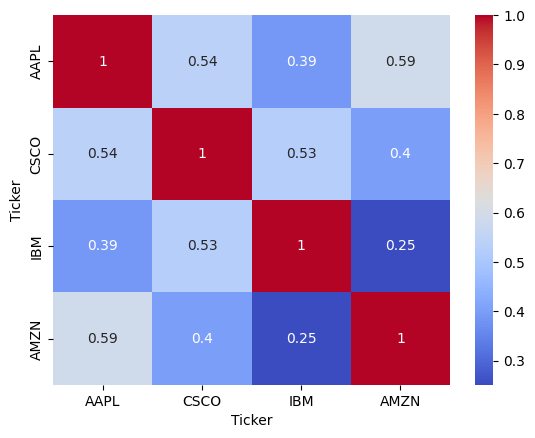

In [7]:
# 상관 계수
corr = stocks.pct_change(1).corr()

# 히트맵으로 시각화
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.show()

In [9]:
# 산술 수익률
stocks.pct_change(1).head()

Ticker,AAPL,CSCO,IBM,AMZN
Date,,,,
2020-01-02,NaN,NaN,NaN,NaN
2020-01-03,-0.009722,-0.016316,-0.007975,-0.012139
2020-01-06,0.007969,0.003569,-0.001787,0.014886
2020-01-07,-0.004703,-0.006485,0.000671,0.002092
2020-01-08,0.016086,0.000632,0.008346,-0.007809


In [10]:
# 로그 수익률
# ln(현재가 / 이전가)
log_ret = np.log(stocks/stocks.shift(1)).dropna()
log_ret.head()

Ticker,AAPL,CSCO,IBM,AMZN
Date,,,,
2020-01-03,-0.009770,-0.016450,-0.008007,-0.012213
2020-01-06,0.007937,0.003563,-0.001788,0.014776
2020-01-07,-0.004715,-0.006506,0.000671,0.002089
2020-01-08,0.015958,0.000631,0.008312,-0.007839
2020-01-09,0.021018,-0.004218,0.010513,0.004788


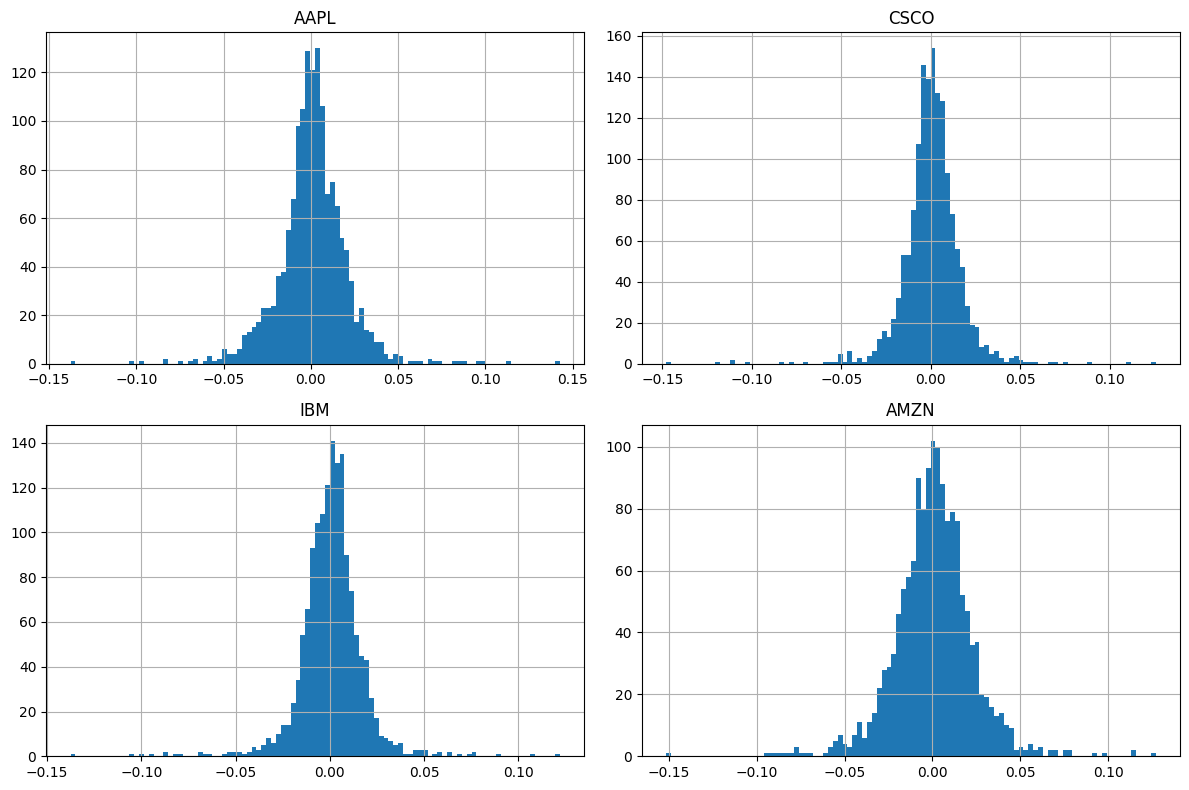

In [11]:
log_ret.hist(bins=100,figsize=(12,8))
plt.tight_layout()

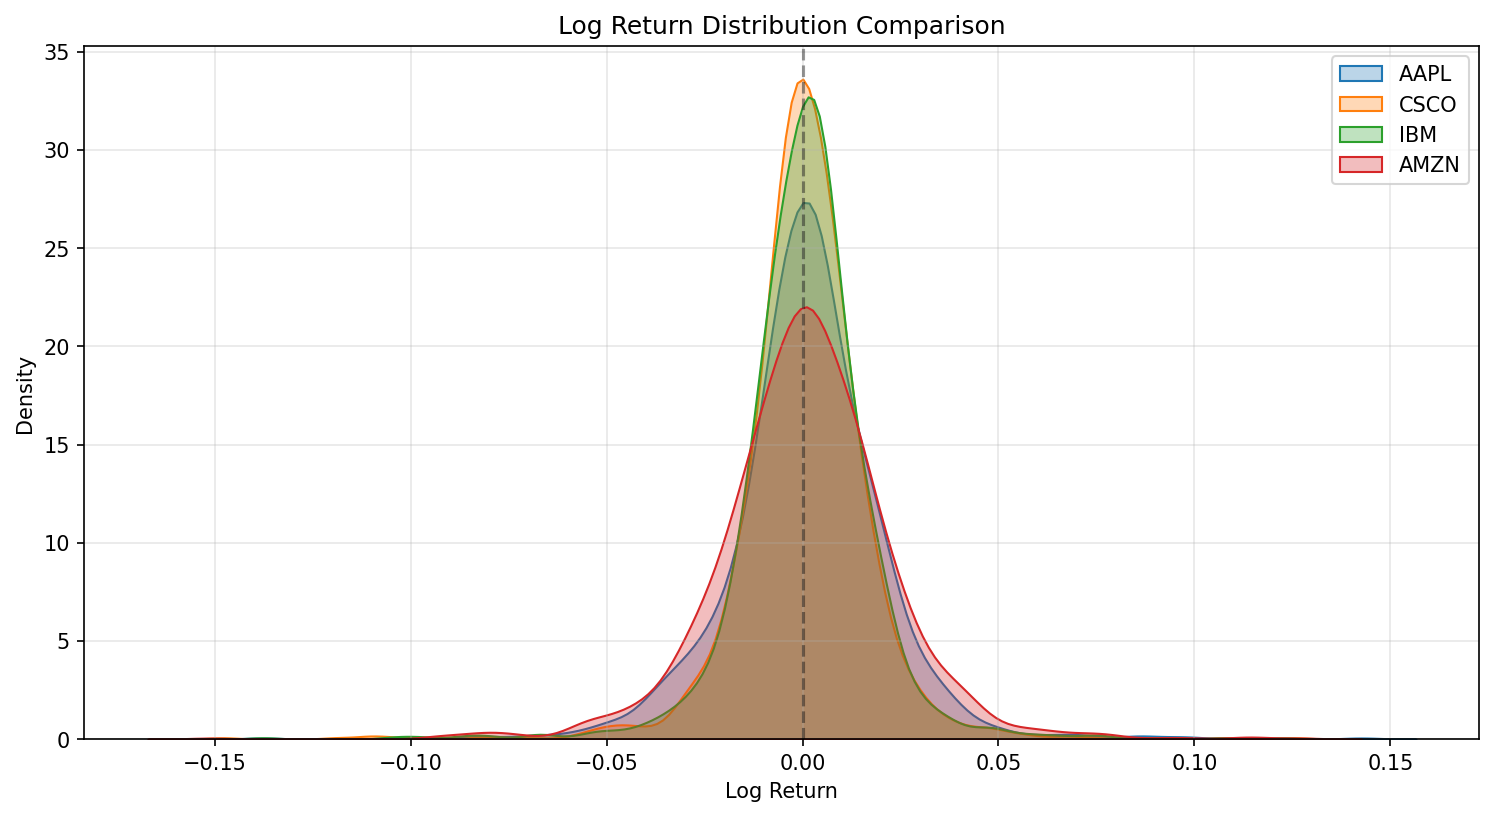

In [12]:
# 히스토그램 겹쳐 그리기 (오버레이)
plt.figure(figsize=(12,6),dpi=150)

# 각 컬럼(Apple, Cisco, IBM, Amazon)을 순회하며 그림
for column in log_ret.columns:
    # kdeplot은 히스토그램을 부드러운 곡선(밀도)으로 보여주어 겹쳐보기에 최적
    sns.kdeplot(log_ret[column], label=column, fill=True, alpha=0.3)

# 그래프 미관 설정
plt.title('Log Return Distribution Comparison')
plt.xlabel('Log Return')
plt.ylabel('Density')
plt.axvline(0, color='black', linestyle='--', alpha=0.4) # 0 기준선 (수익과 손실의 경계)
plt.legend()
plt.grid(alpha=0.3)

# 3. 출력
plt.show()

In [13]:
log_ret.mean()

Ticker
AAPL    0.000883
CSCO    0.000434
IBM     0.000742
AMZN    0.000596
dtype: float64

In [14]:
log_ret.cov() * 252

Ticker,AAPL,CSCO,IBM,AMZN
Ticker,,,,
AAPL,0.100930,0.045916,0.033891,0.066932
CSCO,0.045916,0.072216,0.038700,0.038593
IBM,0.033891,0.038700,0.074782,0.024759
AMZN,0.066932,0.038593,0.024759,0.127500


### **Monte Carlo Simulation**

In [15]:
np.random.seed(101)

print(stocks.columns)

weights = np.array(np.random.rand(4))

print("\nRandom Weights:")
print(weights)

print("\nRebalance:")
weights = weights/np.sum(weights)
print(weights)

# Expected Return
print("\nExpected Portfolio Return:")
exp_ret = np.sum((log_ret.mean() * weights) * 252)
print(exp_ret)

# Expected Volatility - linear algeabra!!!
print("\nExpected Volatility:")
exp_vol = np.sqrt(np.dot(weights.T,np.dot(log_ret.cov()*252,weights)))
print(exp_vol)

# Sharpe Ratio
print("\nSharpe Ratio:")
SR = exp_ret / exp_vol
print(SR)

Index(['AAPL', 'CSCO', 'IBM', 'AMZN'], dtype='object', name='Ticker')

Random Weights:
[0.51639863 0.57066759 0.02847423 0.17152166]

Rebalance:
[0.40122278 0.44338777 0.02212343 0.13326603]

Expected Portfolio Return:
0.16190384026740376

Expected Volatility:
0.24961535557176764

Sharpe Ratio:
0.648613303041985


In [16]:
np.random.seed(101)

num_ports = 5000
all_weights = np.zeros((num_ports,len(stocks.columns)))
ret_arr = np.zeros(num_ports)
val_arr = np.zeros(num_ports)
sharpe_arr = np.zeros(num_ports)

for ind in range(num_ports):
    
    # Weights
    weights = np.array(np.random.rand(4))
    weights = weights/np.sum(weights)

    # Save Weights
    all_weights[ind,:] = weights
    
    # Expected Return
    ret_arr[ind] = np.sum((log_ret.mean() * weights) * 252)
    
    # Expected Volatility
    val_arr[ind] = np.sqrt(np.dot(weights.T,np.dot(log_ret.cov()*252,weights)))
    
    # Sharpe Ratio
    sharpe_arr[ind] = ret_arr[ind] / val_arr[ind]


In [17]:
sharpe_arr.max()

np.float64(0.8272875635489746)

In [18]:
sharpe_arr.argmax()

np.int64(3901)

In [19]:
all_weights[3901,:]

array([0.47947308, 0.0022754 , 0.47582997, 0.04242155])

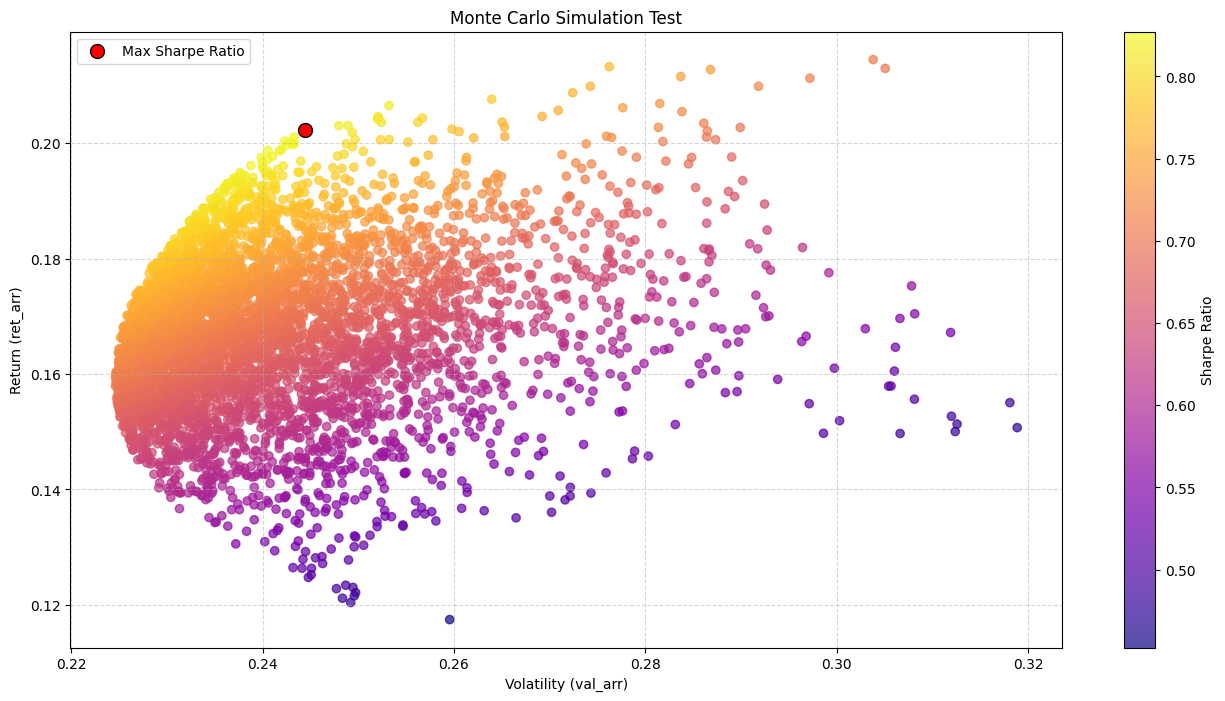

In [21]:
# 1. 최고의 명당(Max Sharpe Ratio) 위치 찾기
max_sr_idx = sharpe_arr.argmax()
max_sr_ret = ret_arr[max_sr_idx]
max_sr_val = val_arr[max_sr_idx]

# 2. 그래프 그리기
plt.figure(figsize=(16,8))
plt.scatter(val_arr, ret_arr, c=sharpe_arr, cmap='plasma', alpha=0.7)
plt.colorbar(label='Sharpe Ratio')

# 축 이름과 제목
plt.title('Monte Carlo Simulation Test')
plt.xlabel('Volatility (val_arr)')
plt.ylabel('Return (ret_arr)')

# ⭐ 최고의 명당
plt.scatter(max_sr_val, max_sr_ret, c='red', s=100, marker='o', edgecolors='black', label='Max Sharpe Ratio')

# 범례 추가 (별이 무엇인지 알려줍니다)
plt.legend(loc='upper left')

# 격자 추가 (가독성을 높여줍니다)
plt.grid(True, linestyle='--', alpha=0.5)

plt.show()

### **라그랑주 승수법(Lagrange Multipliers)**

In [22]:
def get_ret_vol_sr(weights):
    weights = np.array(weights)
    ret = np.sum(log_ret.mean() * weights) * 252
    vol = np.sqrt(np.dot(weights.T,np.dot(log_ret.cov()*252,weights)))
    sr = ret / vol
    return np.array([ret,vol,sr])

In [23]:
from scipy.optimize import minimize

In [36]:
# 1. 목적 함수: 샤프 지수에 -1을 곱해 '최소화' 문제로 변환
# (minimize 함수는 무조건 '낮은' 값을 찾아가기 때문에, 높은 수익률을 '낮은 마이너스'로 바꿔주는 것입니다.)
def neg_sharpe(weights):
    return get_ret_vol_sr(weights)[2] * -1

In [37]:
# 2. 제약 조건 함수: 결과값이 '0'이 되도록 설계해야 함
# (np.sum(weights)가 1이면, 1 - 1 = 0이 되어 제약 조건이 충족되었다고 판단합니다.)
def check_sum(weights):
    # return 0 if the sum of the weights is 1
    return np.sum(weights) - 1

In [39]:
# 3. 제약 조건 설정
cons = ({'type':'eq','fun':check_sum})

In [40]:
# 4. 각 자산별 비중의 범위 (0% ~ 100%)
bounds = ((0,1),(0,1),(0,1),(0,1))

In [42]:
# 5. 초기 추측값 (최적화를 시작할 출발점)
init_guess = [.25,.25,.25,.25]

In [43]:
# 6. 최적화 실행
opt_results = minimize(neg_sharpe,init_guess,method='SLSQP',bounds=bounds,constraints=cons)

In [35]:
opt_results

     message: Optimization terminated successfully
     success: True
      status: 0
         fun: -0.829958989582978
           x: [ 4.764e-01  0.000e+00  5.236e-01  2.448e-17]
         nit: 5
         jac: [-4.300e-05  1.344e-01  3.915e-05  5.769e-03]
        nfev: 25
        njev: 5
 multipliers: [ 3.097e-07]

In [44]:
opt_results.x

array([4.76425056e-01, 0.00000000e+00, 5.23574944e-01, 2.44813668e-17])

In [45]:
get_ret_vol_sr(opt_results.x)

array([0.20383411, 0.2455954 , 0.82995899])

In [57]:
frontier_y = np.linspace(0.11,0.22,100)

In [58]:
def minimize_volatility(weights):
    return get_ret_vol_sr(weights)[1]

In [59]:
frontier_volatility = []

for possible_return in frontier_y:
    cons = ({'type':'eq','fun':check_sum},
            {'type':'eq','fun':lambda w: get_ret_vol_sr(w)[0]-possible_return})
    
    result = minimize(minimize_volatility,init_guess,method='SLSQP',bounds=bounds,constraints=cons)

    frontier_volatility.append(result['fun'])

In [84]:
result

     message: Optimization terminated successfully
     success: True
      status: 0
         fun: 0.30353125352718463
           x: [ 9.305e-01  0.000e+00  6.952e-02  0.000e+00]
         nit: 2
         jac: [ 3.172e-01  1.496e-01  1.210e-01  2.109e-01]
        nfev: 10
        njev: 2
 multipliers: [-9.085e-01  5.509e+00]

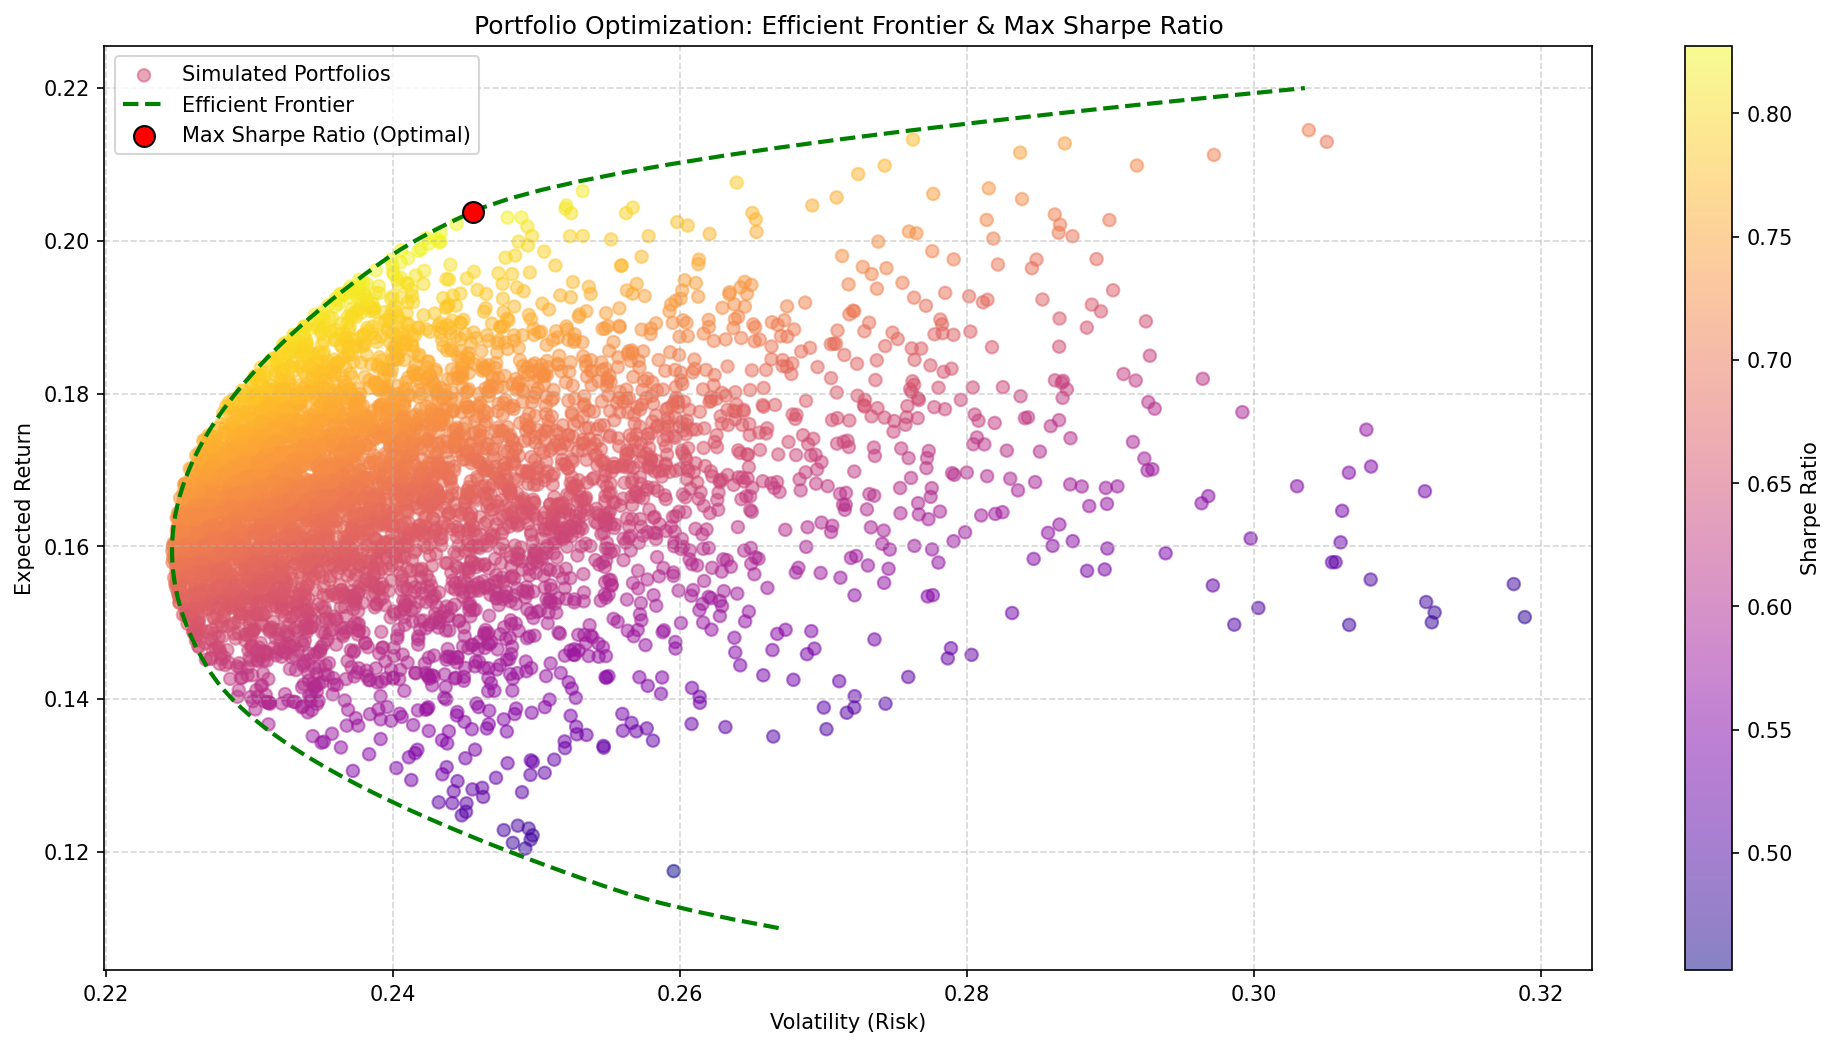

In [69]:
# 1. SLSQP 최적화 결과로 '진정한 정답 점' 좌표 계산
res = get_ret_vol_sr(opt_results.x)
optimal_ret = res[0]
optimal_vol = res[1]

# 2. 차트 그리기
plt.figure(figsize=(16,8),dpi=150)

# 몬테카를로 점들
plt.scatter(val_arr, ret_arr, c=sharpe_arr, cmap='plasma', alpha=0.5, label='Simulated Portfolios')
plt.colorbar(label='Sharpe Ratio')

# 효율적 투자선 (초록 점선)
plt.plot(frontier_volatility, frontier_y, 'g--', linewidth=2, label='Efficient Frontier')

# 빨간 점: 몬테카를로 최고점이 아닌, '수학적 최적점'을 대입!
plt.scatter(optimal_vol, optimal_ret, 
            c='red', s=100, marker='o', edgecolors='black', 
            label='Max Sharpe Ratio (Optimal)',
            zorder=3
)

# 마무리 장식
plt.title('Portfolio Optimization: Efficient Frontier & Max Sharpe Ratio')
plt.xlabel('Volatility (Risk)')
plt.ylabel('Expected Return')
plt.legend(loc='upper left')
plt.grid(True, linestyle='--', alpha=0.5)

plt.show()

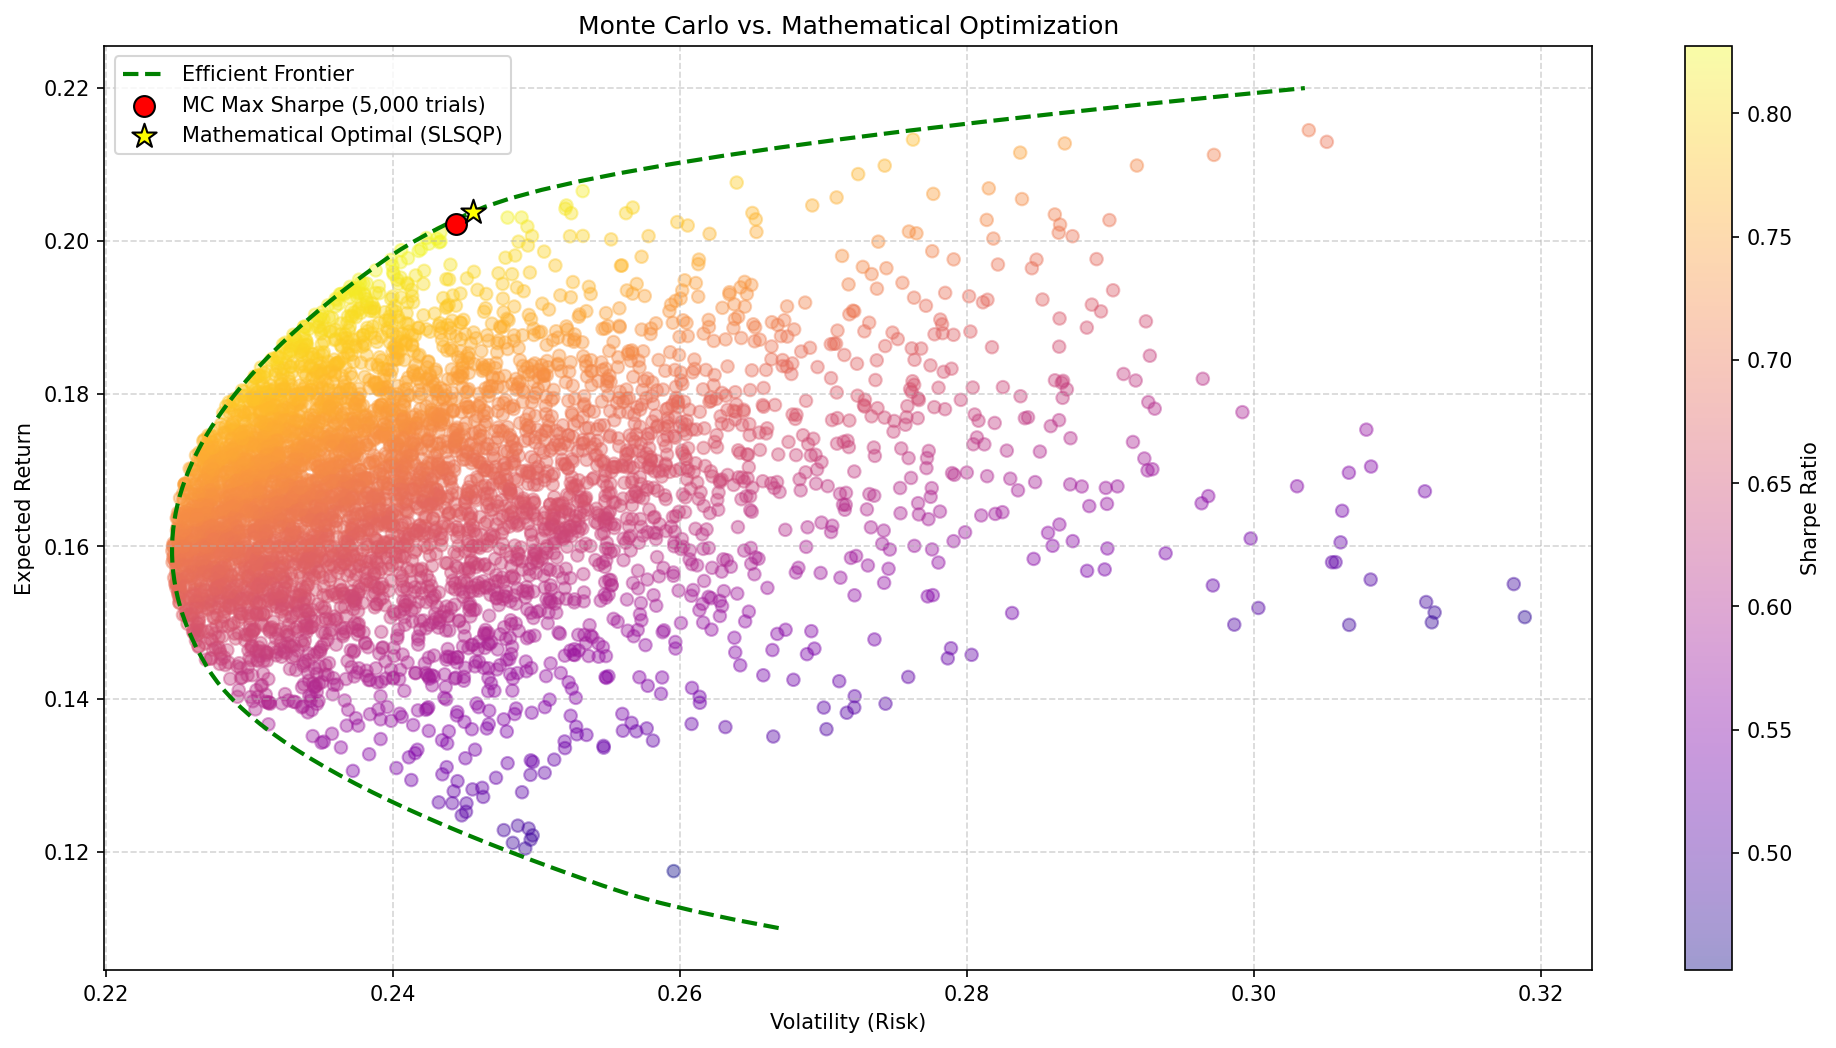

In [73]:
# 1. 수학적 최적화 결과값 계산
res = get_ret_vol_sr(opt_results.x)
opt_vol, opt_ret = res[1], res[0]

plt.figure(figsize=(16,8),dpi=150)

# 배경: 5,000개의 시뮬레이션 점
plt.scatter(val_arr, ret_arr, c=sharpe_arr, cmap='plasma', alpha=0.4, zorder=1)
plt.colorbar(label='Sharpe Ratio')

# 기준: 효율적 투자선 (초록 점선)
plt.plot(frontier_volatility, frontier_y, 'g--', linewidth=2, label='Efficient Frontier', zorder=2)

# 점 1: 몬테카를로 5,000번 중 최고점 (빨간 원)
plt.scatter(max_sr_val, max_sr_ret, c='red', s=100, marker='o', 
            edgecolors='black', label='MC Max Sharpe (5,000 trials)', zorder=3)

# 점 2: 수학적 최적점 (노란 별) - zorder를 가장 높게!
plt.scatter(opt_vol, opt_ret, c='yellow', s=150, marker='*', 
            edgecolors='black', label='Mathematical Optimal (SLSQP)', zorder=4)

plt.title('Monte Carlo vs. Mathematical Optimization')
plt.xlabel('Volatility (Risk)')
plt.ylabel('Expected Return')
plt.legend(loc='upper left')
plt.grid(True, linestyle='--', alpha=0.5)

plt.show()

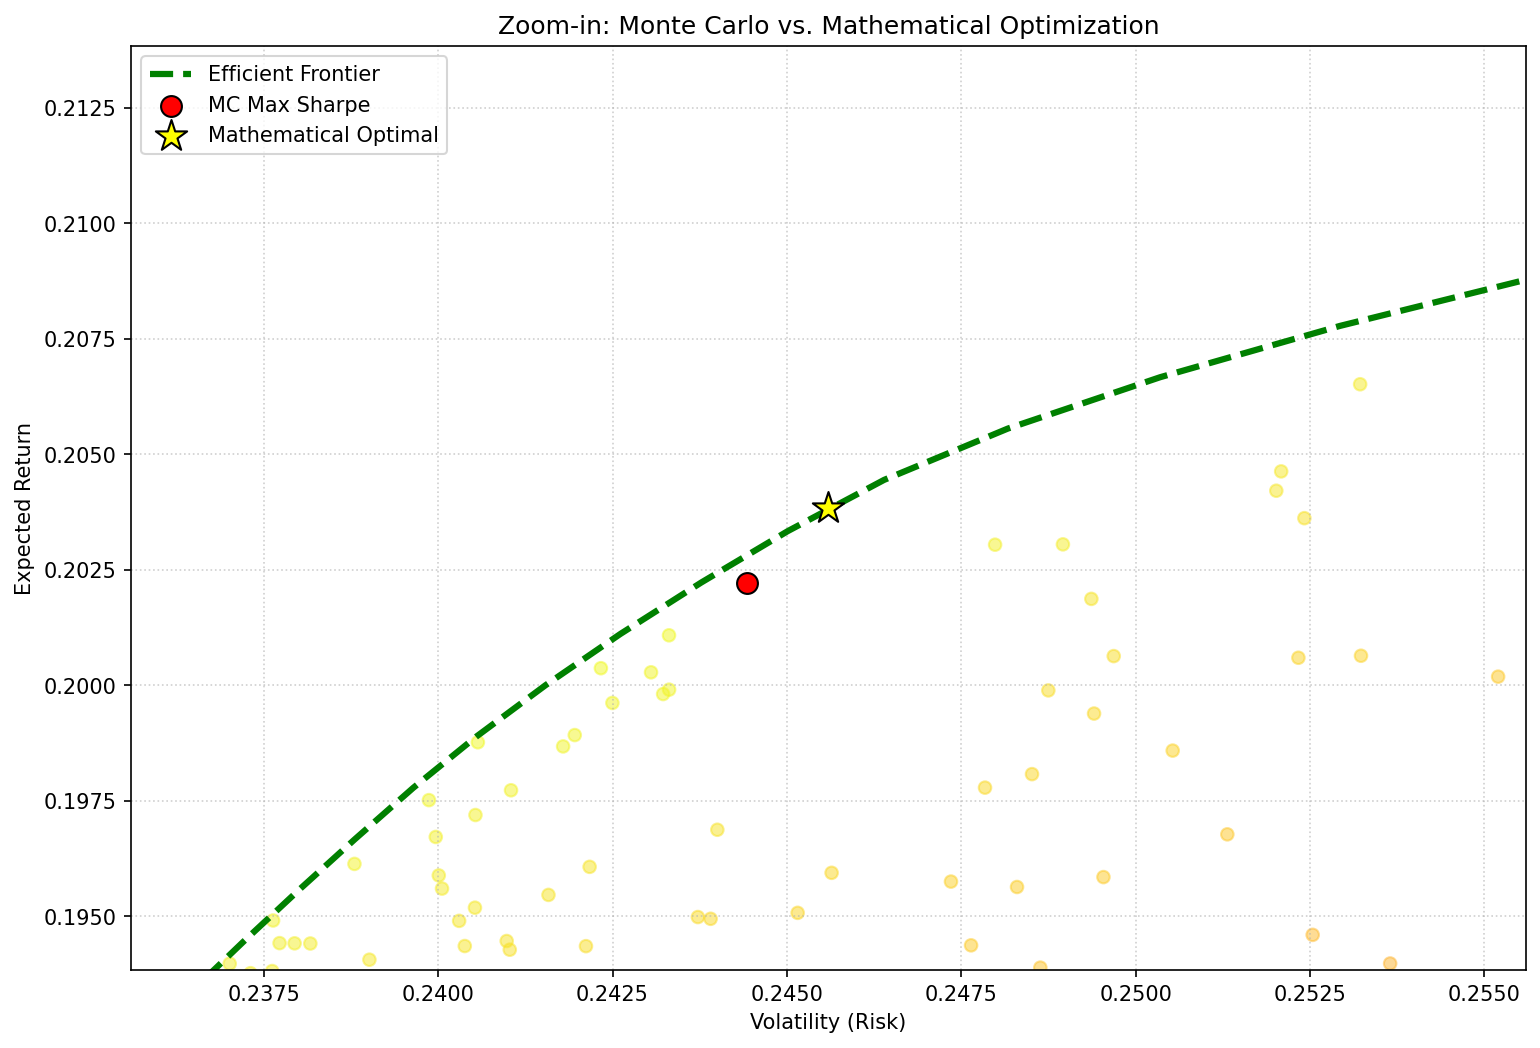

In [83]:
# 1. 시야 범위 설정 (최적점 근처로 좁히기)
# 빨간 점(max_sr_val) 근처로 앞뒤 1~2% 정도만 보여주도록 설정합니다.
zoom_margin = 0.01 

plt.figure(figsize=(12,8),dpi=150)

# 배경 점들과 선 (확대된 상태이므로 더 잘 보입니다)
plt.scatter(val_arr, ret_arr, c=sharpe_arr, cmap='plasma', alpha=0.5, zorder=1)
plt.plot(frontier_volatility, frontier_y, 'g--', linewidth=3, label='Efficient Frontier', zorder=2)

# 점 1: 몬테카를로 최고점
plt.scatter(max_sr_val, max_sr_ret, c='red', s=100, marker='o', 
            edgecolors='black', label='MC Max Sharpe', zorder=3)

# 점 2: 수학적 최적점 (별 모양)
plt.scatter(opt_vol, opt_ret, c='yellow', s=250, marker='*', 
            edgecolors='black', label='Mathematical Optimal', zorder=4)

# --- 🔍 이 부분이 핵심입니다 (확대) ---
plt.xlim(opt_vol - zoom_margin, opt_vol + zoom_margin)
plt.ylim(opt_ret - zoom_margin, opt_ret + zoom_margin)
# ------------------------------------

plt.title('Zoom-in: Monte Carlo vs. Mathematical Optimization')
plt.xlabel('Volatility (Risk)')
plt.ylabel('Expected Return')
plt.legend(loc='upper left')
plt.grid(True, linestyle=':', alpha=0.6)

plt.show()